In [1]:
# Imports --- All of this may not be vital

import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  f1_score, recall_score, precision_score
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import  StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *
# Homemade functions required
from data_prep_functions import *
from interpro_scraping import interpro_scraping_pandas


2.4.0


In [12]:
sklearn_models = {
                 'Logistic Regression':SGDClassifier(loss='log'),
                 "Random Forest - 100 Trees":RandomForestClassifier(),
                 "Random Forest - 1000 Trees":RandomForestClassifier(n_estimators=1000),
                 "Bagging - Decision Tree": BaggingClassifier(n_estimators=100),
                 "Bagging - SVM": BaggingClassifier(base_estimator=SGDClassifier(), n_estimators=100),
                 "Bagging - Logistic Regression": BaggingClassifier(base_estimator=SGDClassifier(loss='log'), n_estimators=100),
                 "Gradient Boosting Classifier - Decision Tree": GradientBoostingClassifier(n_estimators=100),
                 "AdaBoost - Decision Tree":AdaBoostClassifier(n_estimators=100, algorithm='SAMME'),
                 "AdaBoost - Decision Tree - 1000 Estimators":AdaBoostClassifier(n_estimators=1000, algorithm='SAMME'),
                 "AdaBoost - SVM": AdaBoostClassifier(base_estimator=SGDClassifier(), n_estimators=100, algorithm='SAMME'),
                 "AdaBoost - Logistic Regression": AdaBoostClassifier(base_estimator=SGDClassifier(loss='log'), n_estimators=100, algorithm='SAMME'),
                 'XGBoost - Decision Tree':xgb.sklearn.XGBClassifier(n_estimators=100, booster='gbtree', verbosity=0),
                 'XGBoost - Decision Tree - 100 Parallel Trees':xgb.sklearn.XGBClassifier(n_estimators=100, booster='gbtree', verbosity=0, num_parallel_tree=100)
                 }
debug_models = {'xgb':xgb.sklearn.XGBClassifier(n_estimators=100, booster='gbtree', verbosity=0, num_parallel_tree=100)}
                 #"svm": SGDClassifier(),

# Data Imports

In [16]:
### import data used to train classifiers ###

plasma_total_data_names = pd.read_excel("data/"+'gt15_plasma_features_names_biopy_gravy.xlsx', header=0, index_col=0)
csf_total_data_names = pd.read_excel("data/"+'gt15_csf_features_names_biopy_gravy.xlsx', header=0,index_col=0)

## sort into names and features
features_plasma = plasma_total_data_names.copy()
features_plasma = features_plasma.drop(['Corona'], axis=1)
names_plasma = plasma_total_data_names['Corona'].copy()

features_csf = csf_total_data_names.copy()
features_csf = features_csf.drop(['Corona'], axis=1) 
names_csf = csf_total_data_names['Corona'].copy()

### create a merged set
features_plasma_labeled = features_plasma.copy()
features_csf_labeled = features_csf.copy()

features_plasma_labeled['phase_plasma'] = 1
features_csf_labeled['phase_plasma'] = 0

features_merged = features_plasma_labeled.append(features_csf_labeled, ignore_index=True)
names_merged = names_plasma.append(names_csf, ignore_index=True)

# set with no phase labeling names are identical to names merged
features_merged_naive = features_merged.drop(['phase_plasma'], axis=1)

# print(plasma_total_data_names.shape, csf_total_data_names.shape, features_test.shape) ## in case you need to see shapes

## there is a known error here, sometimes there is an Unnamed column just drop it code is available in a 
#lower cell (scaling cell), its a holdover from two merged sets



In [17]:
scaler = MinMaxScaler()
total_data = features_merged_naive.copy()  ## for a regular netsurfp included case
# total_data = subset_features.copy() ### for a subset case --- use this one
total_data = total_data.fillna(0)
total_data_with_names = total_data.copy()
total_data = total_data.drop(['Protein names', 'mass'], axis=1)
scaler = scaler.fit(total_data)
scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)
print(scaled_df.shape)

# total_data_labeled = features_merged.copy()
# total_data_labeled = total_data_labeled.fillna(0)
# total_data_labeled = total_data_labeled.drop(['Protein names'], axis=1)
# scaled_df_total = pd.DataFrame(scaler.transform(total_data_labeled), columns=total_data_labeled.columns)

scaled_df_phase = scaled_df.copy()
scaled_df_phase['phase_plasma'] = features_merged['phase_plasma'].copy()

plasma_data = scaled_df_phase[scaled_df_phase.phase_plasma==1]
plasma_data = plasma_data.drop(['phase_plasma'], axis=1)
scaled_df_plasma = plasma_data #pd.DataFrame(scaler.transform(plasma_data), columns=plasma_data.columns)

csf_data = scaled_df_phase[scaled_df_phase.phase_plasma==0]
csf_data = csf_data.drop(['phase_plasma'], axis=1)
scaled_df_csf = csf_data #pd.DataFrame(scaler.transform(csf_data), columns=csf_data.columns)

#### UNCOMMENT this section for a REGULAR RUN
# #features = features_merged_naive.copy()  # change the dataframe that you want to use here
# features_test = features_test.fillna(0)
# features_test_names = features_test.copy()
# features_test = features_test.drop(['Protein names'], axis=1)
# scaled_test_df = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)


# scaled_df = scaled_df.drop(['Unnamed: 0.1'], axis=1)
# scaled_test_df = scaled_test_df.drop(['Unnamed: 0.1'], axis=1)

(174, 91)


In [18]:
### Data put into classifier and classified


df_local_features_train = scaled_df.copy()
# df_local_protein_names_train = features_test_names['Protein names']
df_local_names = names_merged.copy()

# df_local_features_classify = scaled_features_for_prediction.copy()
# df_local_protein_names_classify = features_for_prediction['Protein names'].copy()

### to keep some things kosher later
df_local_features_train_copy = scaled_df.copy()
df_local_names_copy = names_merged.copy()
# df_local_features_classify_copy = df_local_features_classify.copy()
# df_local_protein_names_classify_copy = df_local_protein_names_classify.copy()

# Learning Models Cycle

In [ ]:
k_fold_splits = 100
predictions = pd.DataFrame()
scaler = MinMaxScaler()
first_frame = True
metrics_frame = pd.DataFrame()
for key, model in sklearn_models.items():
    print(key)
    acc_arry=np.zeros(k_fold_splits)
    prec_arry=np.zeros(k_fold_splits)
    roc_arry=np.zeros(k_fold_splits)
    recall_arry=np.zeros(k_fold_splits)
    choice_data = {}

    feature_imp = pd.DataFrame(columns=list(scaled_df.columns))
    
    correctness_frame = pd.DataFrame()
    

    # #split up our data
    i = 0


    sss = StratifiedShuffleSplit(n_splits=100, test_size=0.1, random_state=2016)
    # skf = StratifiedKFold(n_splits=k_fold_splits, shuffle=True, random_state=35)

    for train_index, test_index in sss.split(df_local_features_train, df_local_names):
        # print(f'Round {i} \n')
        X_train = df_local_features_train.iloc[train_index]
        X_test = df_local_features_train.iloc[test_index]
        y_train = df_local_names.iloc[train_index]
        y_test = df_local_names.iloc[test_index]
        # print(X_train.shape)
        sme = SMOTE(random_state=2016, sampling_strategy=0.7, n_jobs=-1, k_neighbors=12)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
        
        if key == 'meta':
            rfc = RandomForestClassifier()
            rfc.fit(X_train_oversampled, y_train_oversampled)
            X_train_oversampled['meta_feat'] = rfc.predict_proba(X_train_oversampled)[:, 1]
            print(X_train_oversampled.shape, y_train_oversampled.shape)
            model.fit(X_train_oversampled, y_train_oversampled)
            X_test['meta_feat'] = rfc.predict_proba(X_test)[:, 1]
        
        else:
            model.fit(X_train_oversampled, y_train_oversampled)

        

        if first_frame:  # Initialize 
            # print("first frame")
            first_frame = False  # Don't Come back Here
            
            # datadict = {'true':y_test.to_numpy(), 'estimate':model.predict(X_test), 'probability':model.predict_proba(X_test)[:, 1]}
            
            # correctness_frame = pd.DataFrame(data=datadict)
            # correctness_frame['round'] = i

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            'Accuracy':model.score(X_test, y_test), 'Recall':recall_score(y_test, model.predict(X_test)), 
            'Precision':precision_score(y_test, model.predict(X_test)), 'F1':f1_score(y_test, model.predict(X_test))}
            
            metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
            metrics_frame['Round'] = i
            metrics_frame['Classifier'] = key

            
        else:
            # datadict = {'true':y_test.to_numpy(), 'estimate':model.predict(X_test), 'probability':model.predict_proba(X_test)[:, 1]}
            # revolve_frame = pd.DataFrame(data=datadict)
            # revolve_frame['round'] = i
            # correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            'Accuracy':model.score(X_test, y_test), 'Recall':recall_score(y_test, model.predict(X_test)), 
            'Precision':precision_score(y_test, model.predict(X_test)), 'F1':f1_score(y_test, model.predict(X_test))}
            metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
            metrics_revolve_frame['Round'] = i
            metrics_revolve_frame['Classifier'] = key
            metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)

            # print(results)
        i += 1

In [15]:
metrics_frame.to_excel('multi_classifier_comparison.xlsx')

In [7]:
melted_metrics_frame = pd.melt(metrics_frame, id_vars=["Round", "Classifier"])

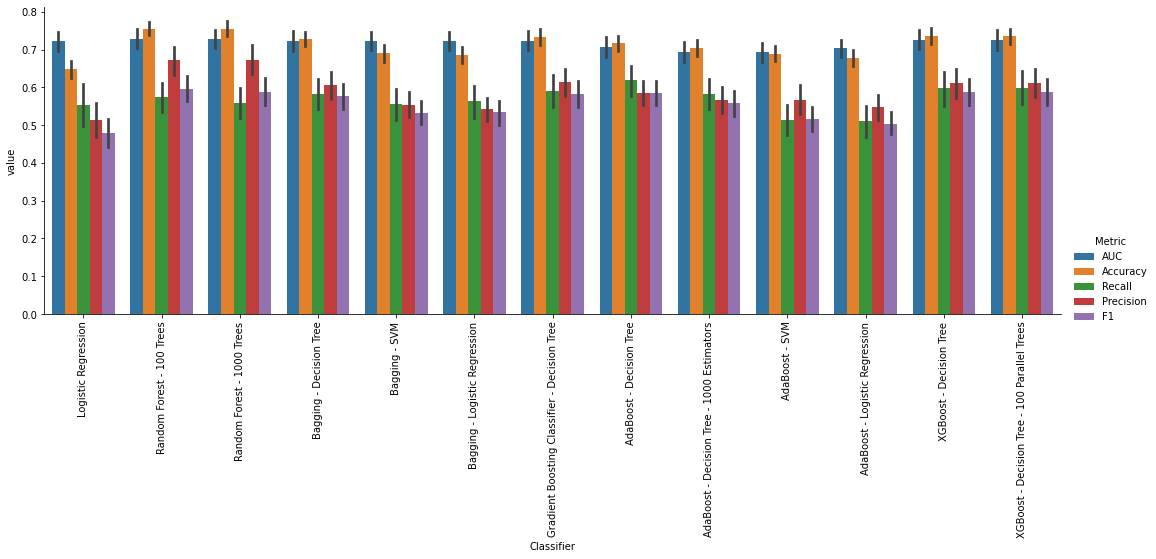

In [8]:
melted_metrics_frame = melted_metrics_frame.rename(columns={'variable':'Metric'})

ax = sns.catplot(data=melted_metrics_frame, kind="bar", x="Classifier", y="value", hue="Metric", height=5, aspect=3)
ax.set_xticklabels(rotation=90)
plt.show()